# Analysis of the QM7 dataset


*Taken from:* https://www.kaggle.com/code/mjmurphy28/predicting-atomization-energy-qm7/notebook

*Original website:* http://quantum-machine.org/datasets/

**Attributes:**

- X: (7165 x 23 x 23), Coulomb matrices, low-level molecular descriptor (Rupp et al., 2012)
- T: (7165), atomization energies (unit: kcal/mol)
- P: (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]
- Z: (7165 x 23), atomic charges
- R: (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules


I.e. it contains 23 atoms and 7165 molecules.

They say 'The Coulomb matrix has built-in invariance to translation and rotation of the molecule', because it is calculated by:

$$C_{ii} = \frac{1}{2} Z_i^{2.4} \text{ and } C_{ij} = \frac{Z_i Z_j}{|R_i - R_j|}$$

where $Z_i$ is the nuclear charge of atom $i$ and $R_i$ is its position. Thus translation and rotation of a molecule (the atoms positions) will not change the value of $C$.


In [1]:
pwd

'/Users/arond.jacobsen/Documents/GitHub/uq-gnn/content/notebooks'

In [2]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import torch
import os
from sklearn.preprocessing import StandardScaler
import pylab 
import scipy.stats as stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


rand_state = 42
np.random.seed(rand_state)

In [5]:
path = os.getcwd() 
print(path)
if os.path.basename(path) == 'notebooks':
    path = os.sep.join(path.split(os.sep)[:-1])
    print(path)
    
os.chdir(path)
from modules.Datasets import QM7_dataset, get_loaders

/Users/arond.jacobsen/Documents/GitHub/uq-gnn/content/notebooks
/Users/arond.jacobsen/Documents/GitHub/uq-gnn/content


In [7]:
# full dataset
data = f'{os.sep}data{os.sep}QM7{os.sep}qm7.mat'
data_path = path+data
dataset = QM7_dataset(path=data_path, device='cpu')

# Construct loaders
graph_info, graph_data = dataset
# you can adjust the test and val size here
loaders = get_loaders(graph_info, graph_data, batch_size=32, test_size=0.2, val_size=0.2,
                      device=torch.device('cpu'), random_state=0, shuffle=True)



100%|██████████████████████████████████████| 7165/7165 [00:11<00:00, 614.31it/s]


In [8]:
train_loader, val_loader, test_loader = tuple(loaders.values())

In [9]:

# values for histogram plots (and included in the model)
check_list = ['target', 'num_nodes', 'edge_lengths', 'edge_coulomb', 'mean_edge_lengths', 'mean_edge_coulomb']
data_dict = {check: np.array([]) for check in check_list}

# converting to singlular data (not batch)
for idx_batch, train_batch in enumerate(train_loader):
    for check in ['target', 'num_nodes', 'edge_lengths', 'edge_coulomb']:
        check_item = getattr(train_batch, check)
        data_dict[check] = np.append(data_dict[check], check_item)
        if check not in ['target', 'num_nodes']: # want the mean per molecule too
            data_dict['mean_'+check] = np.append(data_dict['mean_'+check], np.mean(check_item.numpy()))
            


In [23]:
# the original data format

qm7 = scipy.io.loadmat('data/QM7/qm7.mat')

## Analysis of target variable

Distribution of target variable


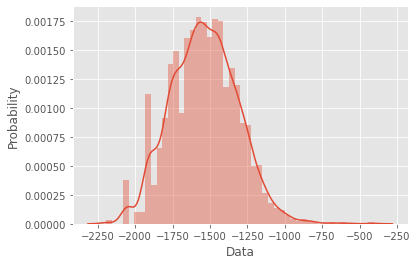

In [32]:
#plt.hist(data_dict['target'], density=True, bins=50)  # density=False would make counts
print('Distribution of target variable')

sns.distplot(data_dict['target']);
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()


In [146]:
np.mean(data_dict['target'])

-1538.0123415793573

In [40]:
np.std(data_dict['target'], ddof=0) # Delta Degrees of Freedom, i.e. of population and not sample

223.02391463228767

QQ-plot of target variable compared to samples from a normal distribution


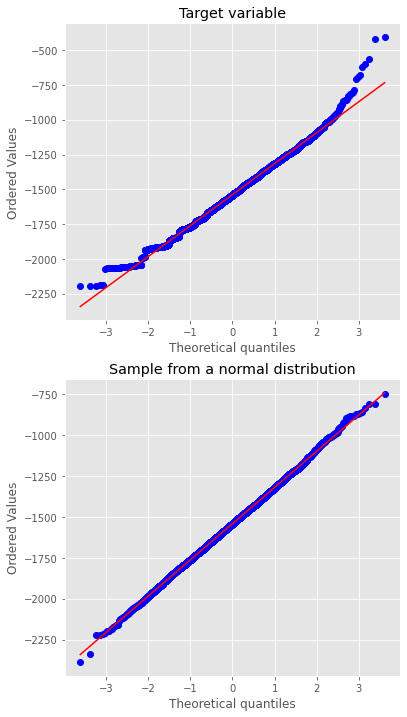

In [148]:
print('QQ-plot of target variable compared to samples from a normal distribution')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 12))
#fig(figsize=(8, 6), dpi=80)
stats.probplot(data_dict['target'], dist="norm", plot=ax1);
ax1.title.set_text('Target variable')
stats.probplot(np.random.normal(np.mean(data_dict['target']), np.std(data_dict['target']), len(data_dict['target'])), dist="norm", plot=ax2);
ax2.title.set_text('Sample from a normal distribution')

plt.show()


**Note:**

Seems like target can be standardize (not normalized) since values lie somewhat on the theoretical quantiles

## Analysis on the edges

In [102]:
data_dict['mean_edge_lengths']

array([], dtype=float64)

Distribution of edge lengths per edge and mean per molecule


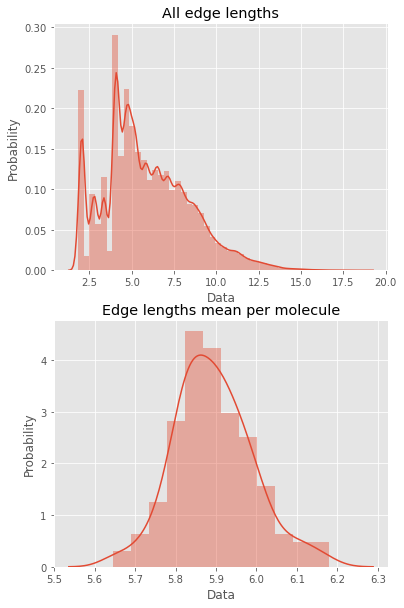

In [38]:
print('Distribution of edge lengths per edge and mean per molecule')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 10))


sns.distplot(data_dict['edge_lengths'], ax=ax1);
ax1.set_ylabel('Probability');
ax1.set_xlabel('Data');
ax1.title.set_text('All edge lengths')

sns.distplot(data_dict['mean_edge_lengths'], ax=ax2);
ax2.set_ylabel('Probability');
ax2.set_xlabel('Data');
ax2.title.set_text('Edge lengths mean per molecule')

plt.show()

we see that the mean is normally distributied, while the edge lengts are gamme or lower tail distributed

Distribution of edge coulomb per edge and mean per molecule


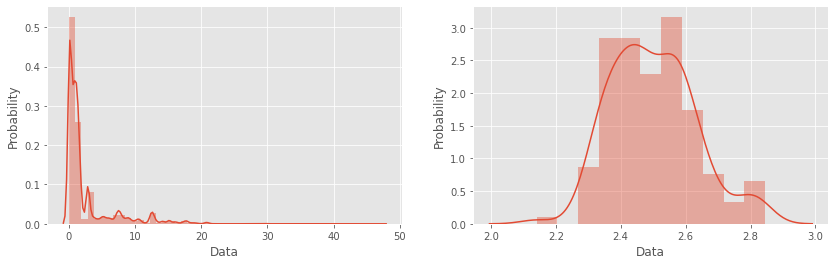

In [40]:
print('Distribution of edge coulomb per edge and mean per molecule')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))


sns.distplot(data_dict['edge_coulomb'], ax=ax1);
ax1.set_ylabel('Probability');
ax1.set_xlabel('Data');

sns.distplot(data_dict['mean_edge_coulomb'], ax=ax2);
ax2.set_ylabel('Probability');
ax2.set_xlabel('Data');
plt.show()

very similar to the edges

In [ ]:
# missing analysis that also are included in the network
['node_from', 'node_to', 'node_graph_index']

## clustering analysis of the data

In [42]:
# want the square 23x23 matrices per molecule
qm7 = scipy.io.loadmat('content/data/QM7/qm7.mat')

In [45]:
# coulomb matrix
qm7['X'][0].shape

(23, 23)

In [48]:
# get indices for upper triange (symmetric) to convert coulomb matrix to vector
iu = np.triu_indices(qm7['X'][0].shape[0],k=0) 

qm7['X'][0][iu].shape

(276,)

In [61]:
(23*23+23)/2 # matches

276.0

In [12]:
# another route, flatten
coulomb_matrix = qm7['X'].reshape(len(qm7['X']), qm7['X'][0].shape[0]**2) # flattening the coulomb matrix

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=30)
coulomb_tsne = tsne.fit_transform(coulomb_matrix)


t-SNE of coulomb matrix


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_80744/3191367764.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label = "atomization energy ")


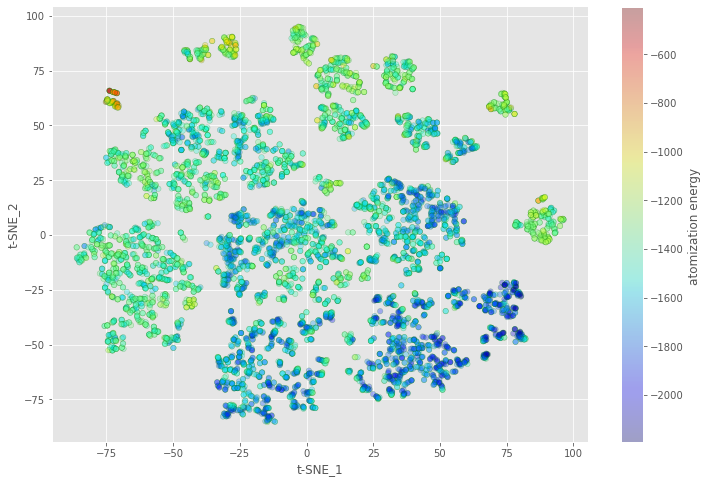

In [13]:
print('t-SNE of coulomb matrix')

plt.figure(figsize=(12,8))
# based on T, atomization energy, the target
scatter = plt.scatter(coulomb_tsne[:,0], coulomb_tsne[:,1], c=qm7['T'], cmap=plt.colormaps['jet'], s=30, edgecolors='green', alpha=0.3)
plt.colorbar(scatter, label = "atomization energy ")
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
sns.despine()
plt.show()

In [113]:
qm7['R'][0].shape

(23, 3)

In [29]:
# flattening
cm = qm7['X'].reshape(len(qm7['X']), qm7['X'][0].shape[0]**2) # coulomb matrix atoms x atoms
z = qm7['Z']# atomic charge, one per atom
r = qm7['R'].reshape(len(qm7['R']), qm7['R'][0].shape[0]*qm7['R'][0].shape[1]) # cartesian coordinates, one per atom

# coulomb and atomic charges

X = np.concatenate((cm, z), axis=1)

X.shape


(7165, 552)

t-SNE of all variables


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_80744/317621358.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label = "atomization energy ")


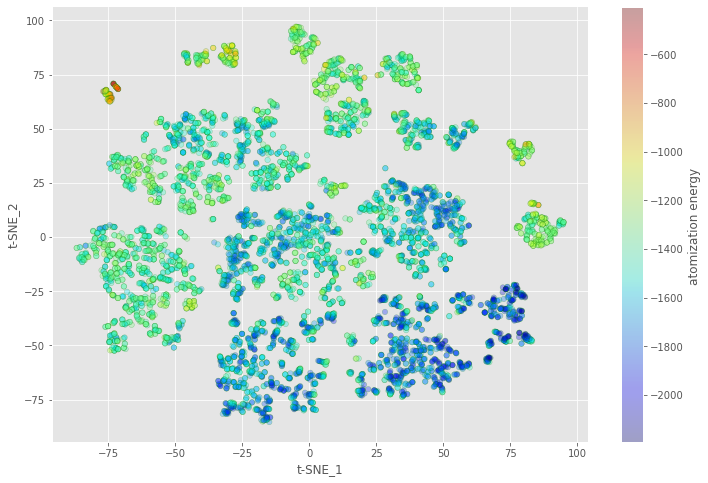

In [30]:
print('t-SNE of all variables')

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,8))
# based on T, atomization energy, the target
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=qm7['T'], cmap=plt.colormaps['jet'], s=30, edgecolors='green', alpha=0.3)
plt.colorbar(scatter, label = "atomization energy ")
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
sns.despine()
plt.show()

In [31]:

# plus coordinates

X = np.concatenate((cm, z, r), axis=1)

X.shape



(7165, 621)

In [20]:
23**2 + 23 + 3*23 # corresponds

621

t-SNE of all variables


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_80744/317621358.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label = "atomization energy ")


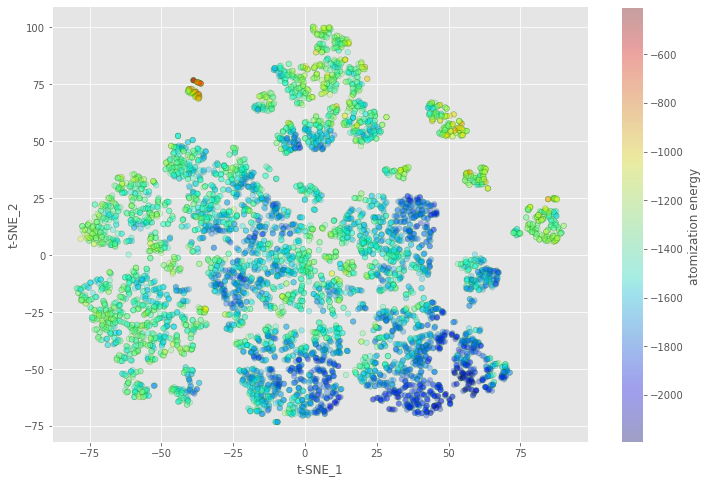

In [32]:
print('t-SNE of all variables')

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,8))
# based on T, atomization energy, the target
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=qm7['T'], cmap=plt.colormaps['jet'], s=30, edgecolors='green', alpha=0.3)
plt.colorbar(scatter, label = "atomization energy ")
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
sns.despine()
plt.show()

By including some of the other features the t-SNE does not separate the high and low atomization energies that much.


### PCA of the coulomb, variance explained

In [131]:
pca = PCA(n_components=50)
 
# Fit and transform data
coulomb_matrix_scaled = StandardScaler().fit_transform(coulomb_matrix)
reduced_features = pca.fit_transform(coulomb_matrix)

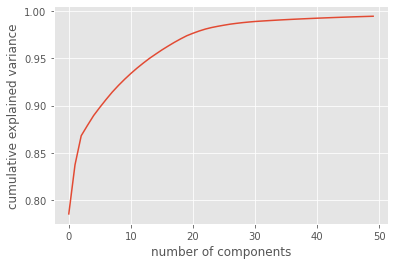

In [132]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [135]:
# considering
23*23

529

nothing to conclude since we need all the edges so some transformation of the coulumb matrix is not relevant, but could be if we were not using a GNN

### standardization

In [61]:

print(data_dict['target'].reshape(-1, 1)[:5])

scalar = StandardScaler()
# standardization of dependent variables
scaled = scalar.fit_transform(data_dict['target'].reshape(-1, 1)) 

print(scaled[:5])

unscaled = scalar.inverse_transform(scaled)
print(unscaled[:5])


[[-1688.27001953]
 [-1853.34997559]
 [-1230.06005859]
 [-1155.34997559]
 [-1935.64001465]]
[[-0.673729  ]
 [-1.41391848]
 [ 1.38080386]
 [ 1.71579073]
 [-1.78289254]]
[[-1688.27001953]
 [-1853.34997559]
 [-1230.06005859]
 [-1155.34997559]
 [-1935.64001465]]


---

# OLD: Getting QM7 ready for dataloaders (for Datasets.py)

In [88]:
pwd

'/Users/arond.jacobsen/Documents/GitHub/uq-gnn/content'

In [92]:
qm7 = scipy.io.loadmat('data/QM7/qm7.mat')

In [93]:
qm7['X'].shape[0]

7165

In [46]:
# coulomb matrix of first molecule

qm7['X'][0][:5,:5]

array([[36.858105  ,  2.9076326 ,  2.907612  ,  2.9075644 ,  2.9053485 ],
       [ 2.9076326 ,  0.5       ,  0.29672   ,  0.29671896,  0.2966784 ],
       [ 2.907612  ,  0.29672   ,  0.5       ,  0.29671845,  0.29667813],
       [ 2.9075644 ,  0.29671896,  0.29671845,  0.5       ,  0.29667678],
       [ 2.9053485 ,  0.2966784 ,  0.29667813,  0.29667678,  0.5       ]],
      dtype=float32)

In [48]:
# atom energies (see periodic table)
#    - from here we see it consists of CH4 (which is methane)
# note: this ordering varies per molecule
qm7['Z'][0][:5]

array([6., 1., 1., 1., 1.], dtype=float32)

### formatting the dataset to Datasets.py

In [18]:
print('total atoms with charges: ', (qm7['Z']>0).sum())
print('total atoms with coordinates: ', ((qm7['R']**2).sum(axis=2)>0).sum())
# the same thus former can be used from self.num_nodes

total atoms with charges:  110650
total atoms with coordinates:  110650


In [3]:
# it needs the following attributes

# GRAPH/MOLECULE RELATED:

# Number of graphs in the dataset, i.e. molecules
num_graphs = len(qm7['T'][0]) # T is atomization energies (target)

# Graph list, each molecule has a
graph_list = torch.tensor(range(num_graphs))

# the energy of each molecule
molecule_energy = torch.tensor(qm7['T'][0])

# NODE/ATOM RELATED:

# i.e. atoms, each atom will be distinct
# total charges higher than 0 (there are no negative and 0 charged atoms, see above)
num_nodes = int((qm7['Z']>0).sum())

node_list = torch.tensor(range(num_nodes))

# Node graph index, molecule number each atom belongs to
node_graph_index = []

# Node coordinates
node_coordinates = []

# Node atomic charge
node_charge = [0]*num_nodes # currently empty


# EDGE RELATED:

# Edge list - fully conected graphs due to 
edge_list = []

# the coulomb value for each edge
edge_coulomb = []


# keeping note of atom indices globally (i.e. for all graphs and w.r.t. num_nodes)
global_idx = 0
# looping each molecule
for molecule in graph_list:
    
    # each nodes index in current graph (globally)
    nodes_idx_graph = [local_idx + global_idx for local_idx in list(range((qm7['Z'][molecule]>0).sum()))]
    
    # looping each atom/node in current molecule
    for node_idx in range((qm7['Z'][molecule]>0).sum()) :
        node_graph_index.append(molecule) # saving which molecule this atom belongs to
        node_coordinates.append(qm7['R'][molecule][node_idx]) # saving nodes/atoms coordinate
        node_charge[global_idx] = qm7['Z'][molecule][node_idx] # saving each nodes/atoms energy
        
        # looping all neighbouring nodes/atoms in graph/molecule (based on global node index)
        # creating edge list, note: fully connected
        for idx, neighbouring_node in enumerate(nodes_idx_graph):
            # if not current atom_idx (don't want edges going to themselvel)
            if neighbouring_node != global_idx:
                # creating the edge list
                edge_list.append([global_idx, neighbouring_node])
                # coulomb value per edge, note: symmetric
                edge_coulomb.append(qm7['X'][molecule][node_idx, idx])
        
        global_idx += 1

assert num_nodes == global_idx, 'inconsistencies noticed'


#self.node_graph_index = torch.tensor(node_coordinates)

#self.node_coordinates = torch.tensor(node_coordinates)

#self.node_charge = torch.tensor(node_charge)

#self.edge_list = torch.tensor(edge_list)

#self.edge_coulomb = torch.tensor(edge_coulomb)

# For training and batching

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

In [12]:
batch_size=64
test_size=0.2
val_size=0.2
random_state=42
shuffle=True

In [14]:
train_data, test_data = train_test_split(graph_list, test_size=test_size, random_state=random_state,shuffle=shuffle)

In [9]:
graph_list

tensor([   0,    1,    2,  ..., 7162, 7163, 7164])

in til train.py script